In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

Using TensorFlow backend.
/home/shuvendu/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

At this point, there are two ways you could proceed:
 1. Running the convolutional base over your dataset, recording its output to a
Numpy array on disk, and then using this data as input to a standalone, densely
connected classifier. This solution is fast and cheap to run, because it only requires running the convolutional
base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t
allow you to use data augmentation.

2. Extending the model you have (conv_base) by adding Dense layers on top, and
running the whole thing end to end on the input data. This will allow you to use
data augmentation, because every input image goes through the convolutional
base every time it’s seen by the model. But for the same reason, this technique is
far more expensive than the first

# Option 1: Fast feature extraction without data augmentation

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [4]:
base_dir = '/home/shuvendu/Documents/datasets/Cat_and_Dog_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size=20

In [7]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(directory, 
                                            target_size=(150, 150), 
                                            batch_size=batch_size, 
                                            class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [8]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [22]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### Defining and training the densly connected layers

In [9]:
from keras import layers, losses, models, optimizers, metrics

In [18]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss=losses.binary_crossentropy, metrics=['acc'])

In [23]:
history = model.fit(train_features, 
                    train_labels, 
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels)
                   )

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s - loss: 0.6004 - acc: 0.6830 - val_loss: 0.4540 - val_acc: 0.8330
Epoch 2/30
2000/2000 [==============================] - 0s - loss: 0.4390 - acc: 0.8030 - val_loss: 0.3823 - val_acc: 0.8500
Epoch 3/30
2000/2000 [==============================] - 0s - loss: 0.3589 - acc: 0.8455 - val_loss: 0.3267 - val_acc: 0.8850
Epoch 4/30
2000/2000 [==============================] - 0s - loss: 0.3156 - acc: 0.8725 - val_loss: 0.3041 - val_acc: 0.8920
Epoch 5/30
2000/2000 [==============================] - 0s - loss: 0.2891 - acc: 0.8840 - val_loss: 0.2860 - val_acc: 0.8930
Epoch 6/30
2000/2000 [==============================] - 0s - loss: 0.2755 - acc: 0.8845 - val_loss: 0.2743 - val_acc: 0.9000
Epoch 7/30
2000/2000 [==============================] - 0s - loss: 0.2516 - acc: 0.9025 - val_loss: 0.2703 - val_acc: 0.8970
Epoch 8/30
2000/2000 [==============================] - 0s - loss: 0.2329 - a

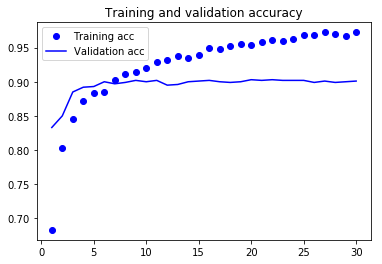

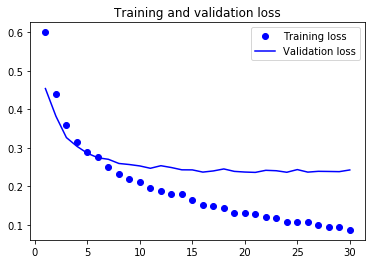

In [24]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Option 2: FEATURE EXTRACTION WITH DATA AUGMENTATION

In [25]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Before you compile and train the model, it’s very important to freeze the convolutional base. Freezing a layer or set of layers means preventing their weights from being
updated during training. If you don’t do this, then the representations that were previously learned by the convolutional base will be modified during training. Because
the Dense layers on top are randomly initialized, very large weight updates would be
propagated through the network, effectively destroying the representations previously
learned.

In [26]:
print('This is the number of trainable weights ''before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [27]:
conv_base.trainable = False
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4


### Training the model with conv base frozen

In [28]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   height_shift_range=.2,
                                   width_shift_range=.2, 
                                   shear_range=.2, 
                                   zoom_range=.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

In [32]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

In [33]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30, 
                              validation_data=validation_generator, 
                              validation_steps=50)

Epoch 1/30
100/100 [==============================] - 34s - loss: 0.4649 - acc: 0.7515 - val_loss: 0.2076 - val_acc: 0.9210
Epoch 2/30
100/100 [==============================] - 32s - loss: 0.2912 - acc: 0.8760 - val_loss: 0.1275 - val_acc: 0.9560
Epoch 3/30
100/100 [==============================] - 32s - loss: 0.2210 - acc: 0.9075 - val_loss: 0.1345 - val_acc: 0.9410
Epoch 4/30
100/100 [==============================] - 31s - loss: 0.1748 - acc: 0.9320 - val_loss: 0.1007 - val_acc: 0.9540
Epoch 5/30
100/100 [==============================] - 31s - loss: 0.1652 - acc: 0.9380 - val_loss: 0.1107 - val_acc: 0.9570
Epoch 6/30
100/100 [==============================] - 31s - loss: 0.1483 - acc: 0.9410 - val_loss: 0.0986 - val_acc: 0.9610
Epoch 7/30
100/100 [==============================] - 32s - loss: 0.1315 - acc: 0.9455 - val_loss: 0.0725 - val_acc: 0.9730
Epoch 8/30
100/100 [==============================] - 32s - loss: 0.1282 - acc: 0.9480 - val_loss: 0.0730 - val_acc: 0.9750
Epoch 9/

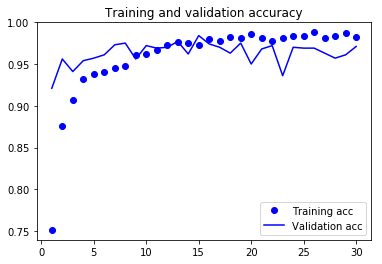

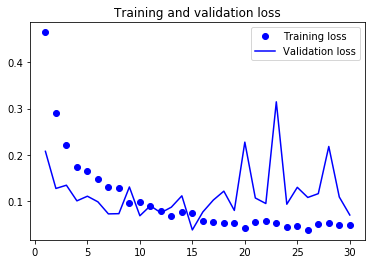

In [34]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine-tuning

the steps for fine-tuning a network are as follow:<br/>
1 Add your custom network on top of an already-trained base network.<br/>
2 Freeze the base network.<br/>
3 Train the part you added.<br/>
4 Unfreeze some layers in the base network.<br/>
5 Jointly train both these layers and the part you added.

In [35]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [36]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 15s - loss: 0.0255 - acc: 0.9890 - val_loss: 0.0899 - val_acc: 0.9750
Epoch 2/100
100/100 [==============================] - 15s - loss: 0.0176 - acc: 0.9930 - val_loss: 0.0740 - val_acc: 0.9780
Epoch 3/100
100/100 [==============================] - 15s - loss: 0.0078 - acc: 0.9975 - val_loss: 0.1062 - val_acc: 0.9760
Epoch 4/100
100/100 [==============================] - 15s - loss: 0.0050 - acc: 0.9980 - val_loss: 0.0690 - val_acc: 0.9820
Epoch 5/100
100/100 [==============================] - 15s - loss: 0.0150 - acc: 0.9950 - val_loss: 0.0948 - val_acc: 0.9800
Epoch 6/100
100/100 [==============================] - 15s - loss: 0.0059 - acc: 0.9980 - val_loss: 0.0930 - val_acc: 0.9780
Epoch 7/100
100/100 [==============================] - 15s - loss: 0.0104 - acc: 0.9960 - val_loss: 0.1035 - val_acc: 0.9780
Epoch 8/100
100/100 [==============================] - 15s - loss: 0.0182 - acc: 0.9930 - val_loss: 0.1394 - val_acc: 0.9730


100/100 [==============================] - 15s - loss: 0.0036 - acc: 0.9995 - val_loss: 0.1474 - val_acc: 0.9750
Epoch 67/100
100/100 [==============================] - 15s - loss: 0.0074 - acc: 0.9975 - val_loss: 0.1752 - val_acc: 0.9760
Epoch 68/100
100/100 [==============================] - 15s - loss: 0.0103 - acc: 0.9960 - val_loss: 0.1491 - val_acc: 0.9780
Epoch 69/100
100/100 [==============================] - 15s - loss: 0.0057 - acc: 0.9990 - val_loss: 0.1543 - val_acc: 0.9750
Epoch 70/100
100/100 [==============================] - 15s - loss: 0.0108 - acc: 0.9970 - val_loss: 0.1469 - val_acc: 0.9720
Epoch 71/100
100/100 [==============================] - 15s - loss: 0.0038 - acc: 0.9980 - val_loss: 0.1682 - val_acc: 0.9740
Epoch 72/100
100/100 [==============================] - 15s - loss: 0.0096 - acc: 0.9975 - val_loss: 0.1998 - val_acc: 0.9720
Epoch 73/100
100/100 [==============================] - 15s - loss: 0.0031 - acc: 0.9990 - val_loss: 0.1753 - val_acc: 0.9740
Epoch

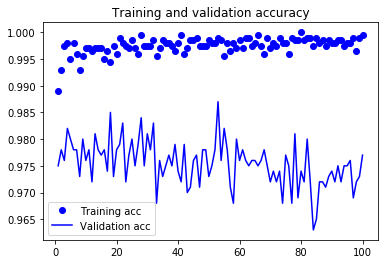

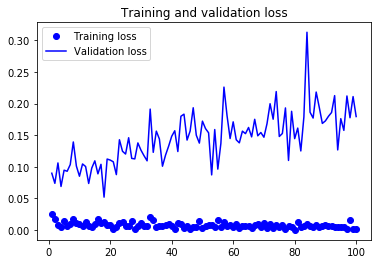

In [37]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
model.save('dogs_and_cal_small_with_vgg16.h5')